In [1]:
using Plots

using NCDatasets
using Statistics: mean

data folders

In [2]:
data_folder = "/central/scratch/bischtob/gcm_ngw/netcdf/"
combined_file = "/central/scratch/bischtob/gcm_ngw/netcdf/combined.nc"
analysis_folder = "/central/scratch/bischtob/gcm_ngw/analysis/"

"/central/scratch/bischtob/gcm_ngw/analysis/"

check if combined file extist, otherwise create it

In [3]:
if !isfile(combined_file)
    files = sort(readdir(data_folder, join=true))
    ds_out = NCDataset(combined_file, "c")

    # Set up two distinct variable classes as they have
    # different sizes
    ds =   ds = NCDataset(files[1], "r")
    vars_grid = ["long", "lat", "level"]
    vars_physical = setdiff(keys(ds), vars_grid)

    # Dimensions from grid variables
    for var in vars_grid
        ds_out.dim[var] = length(ds[var])
    end

    # Declare & fill grid variables
    for var in vars_grid
        ncvar = defVar(ds_out, var, eltype(ds[var]), (var,), attrib=ds[var].attrib)
        ncvar[:] = ds[var][:]
    end

    # Read and aggregate physical variables
    var_dict = Dict(var => [] for var in vars_physical)
    for file in files
        ds_tmp = NCDataset(file, "r")
        for var in vars_physical
            push!(var_dict[var], ds_tmp[var][:])
        end
    end
    var_dict = Dict(var => vcat(var_dict[var]...) for var in vars_physical)

    # Set time dimension, declare & fill time variable
    var = "time"
    ds_out.dim[var] = length(var_dict[var])
    ncvar = defVar(ds_out, var, eltype(ds[var]), (var,), attrib=ds[var].attrib)
    ncvar[:] = var_dict[var]

    # Declare & fill physical variables
    for var in setdiff(vars_physical, ["time"])
        ncvar = defVar(ds_out, var, eltype(ds[var]), ("time", "long", "lat", "level"), attrib=ds[var].attrib)
        ncvar[:] = var_dict[var]
    end
end

ErrorException: syntax: `global ncvar`: ncvar is a local variable in its enclosing scope

load grid

In [23]:
ds = NCDataset(combined_file, "r")

lon = ds["long"][:]
lat = ds["lat"][:]
z = (ds["level"][:] .+ 6320.032e3) # height in kilometers
time = ds["time"][:] # time in days
θ = ds["thd"][:]
u = ds["u"][:]
v = ds["v"][:]
w = ds["w"][:]

data = Dict("u" => u, "v" => v, "w" => w, "θ" => θ)
nothing

# surface temperature
_grav = 9.81
_N = 0.01
_cp = 1004.50843286
_Ω = 0.0
_a = 6.371 * 10^6 / 125
_R_d = 287.002409389
_kappa = 2 / 7
u_0 = 20.0
G = _grav^2 / (_N^2 * _cp)
T_eq = 300.0
p_eq = 1e5

T_s = G .+ (T_eq .- G) .* exp.( -(u_0 .* _N^2) ./ (4 .* _grav.^2) .* (u_0 .+ 2 .* _Ω .*_a) .* (cos.(2 .* lat ./ 180.0 .* π) .- 1))
T_b = G .* (1 .- exp.((_N.^2 ./ _grav) .* z'.* 1e3)) .+ T_s .* exp.((_N.^2 ./ _grav) .* z')
p_s = p_eq .* exp.( u_0 ./ (4 .* G .* _R_d) .* (u_0 .+ 2 .* _Ω .*_a) .* (cos.(2 .* lat./ 180.0 .* π) .- 1)) .* (T_s ./ T_eq).^(1 ./_kappa)
p =  p_s .* (G ./ T_s .* exp.(-_N.^2 ./ _grav .* z') .+ 1 .- G ./ T_s).^(1 ./ _kappa)
θ_b = T_s .* ( p_eq ./ p_s ).^(_kappa) .* exp.(_N^2 ./ _grav .* z')
θ_b = reshape(θ_b[:, :, :, :], (1, 1, length(lat), length(z)))
dθ = θ .- θ_b

println("dimensions: ", size(θ))

dimensions: (358, 37, 19, 51)


In [ ]:
ind = 1
maximum(data["u"][ind, :, :, :]), maximum(data["v"][ind, :, :, :]), maximum(data["w"][ind, :, :, :])

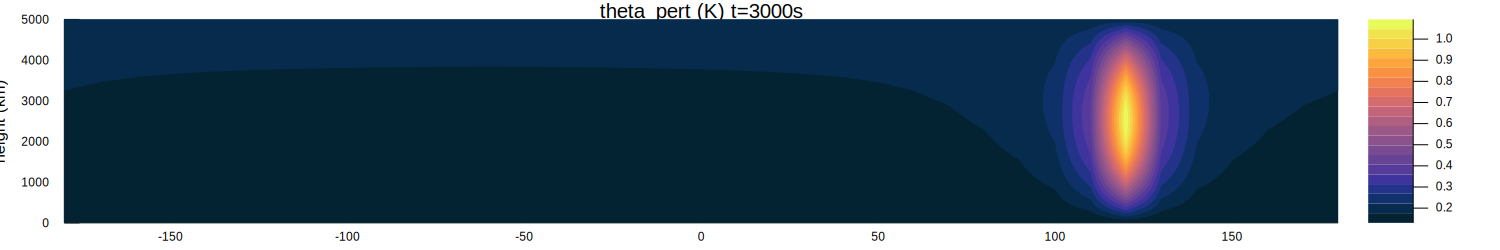

In [22]:
nlev = 20
ylab = "height (km)"
p1 = contourf(lon, z, dθ[1, :, 10, :]' .- 1, xlabel="longitude", ylabel=ylab, color=:thermal, levels=nlev, linewidth=0)

fig = plot(p1, size=(1500, 250), title=["theta_pert (K) t=3000s" ""])

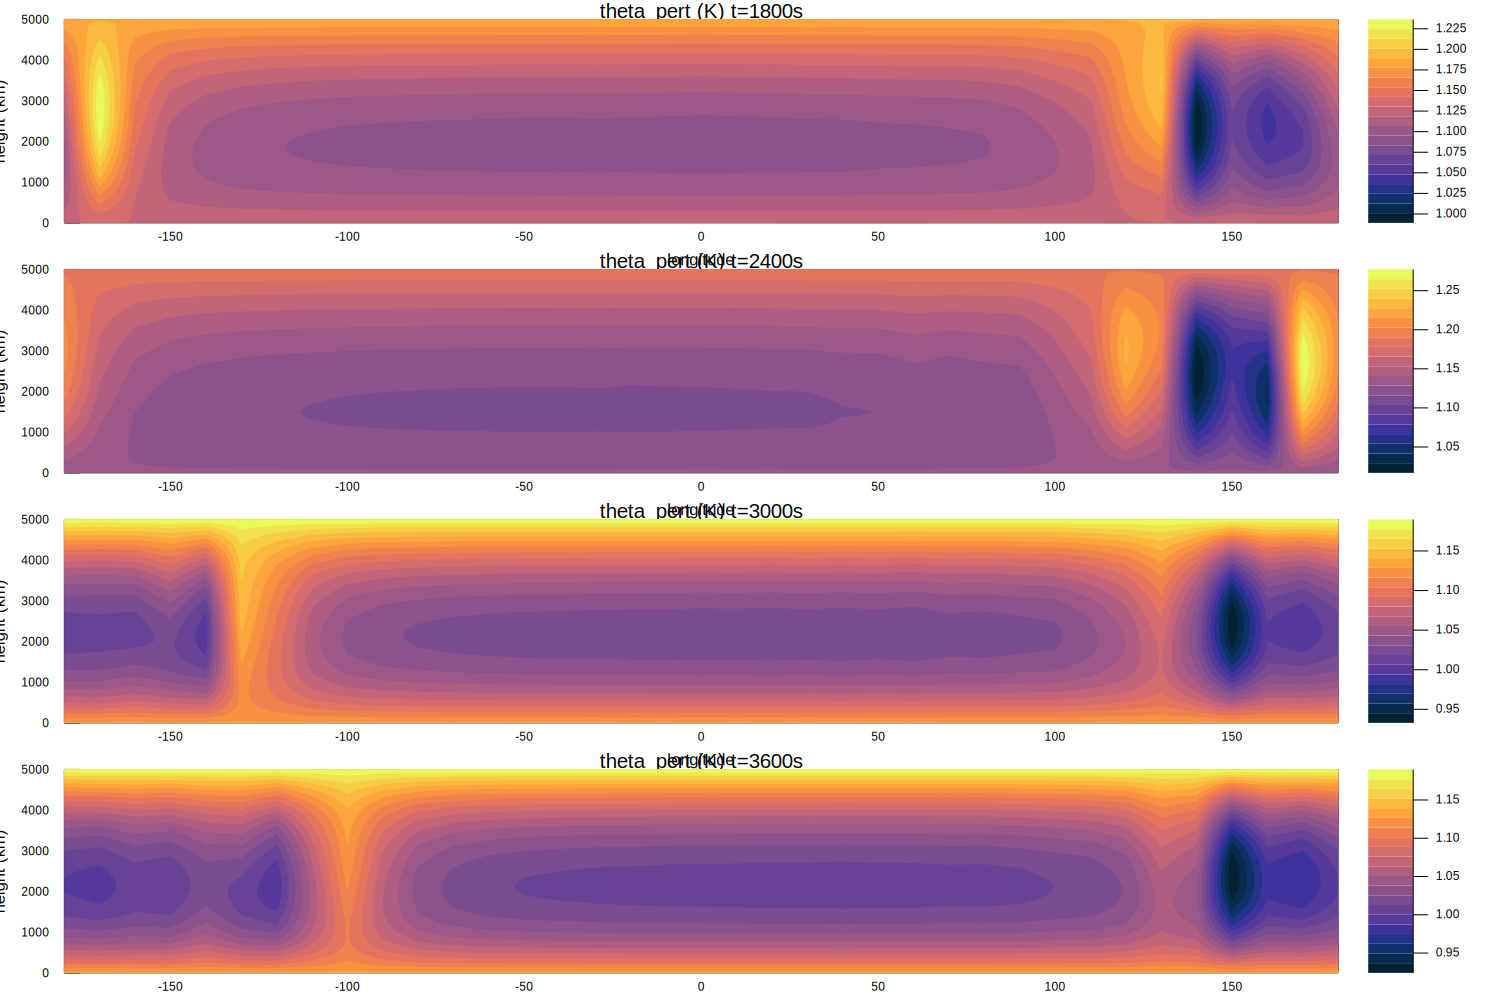

In [26]:
nlev = 20
ylab = "height (km)"
lev = 20 #range(0,1.5,length=10)
cg = cgrad([:blue, :white, :red])
cd = cgrad([:blue, :white, :red])
p1 = contourf(lon, z, dθ[174, :, 10, :]', xlabel="longitude", ylabel=ylab, color=:thermal, levels=lev, linewidth=0)
p2 = contourf(lon, z, dθ[132, :, 10, :]', xlabel="longitude", ylabel=ylab, color=:thermal, levels=lev, linewidth=0)
p3 = contourf(lon, z, dθ[290, :, 10, :]', xlabel="longitude", ylabel=ylab, color=:thermal, levels=lev, linewidth=0)
p4 = contourf(lon, z, dθ[end, :, 10, :]', xlabel="longitude", ylabel=ylab, color=:thermal, levels=lev, linewidth=0)

fig = plot(p1, p2, p3, p4, layout=(4, 1), size=(1500, 1000), title=["theta_pert (K) t=1800s" "theta_pert (K) t=2400s" "theta_pert (K) t=3000s" "theta_pert (K) t=3600s"])

In [27]:
anim = @animate for i = 1:length(time)
    nlev = 20
    ylab = "height (km)"
    cg = cgrad([:blue, :white, :red])
    cd = cgrad([:blue, :white, :red])
    p1 = contourf(lon, z, dθ[i, :, 10, :]', xlabel="longitude", ylabel=ylab, color=:thermal, levels=nlev, linewidth=0)

    plot(p1, size=(1500, 250), title=["theta_pert (K) t=$(i*10) s" ""])
end

mp4(anim, "theta.mp4", fps = 10) # hide

┌ Info: Saved animation to 
│   fn = /central/scratch/bischtob/gcm_ngw/analysis/theta.mp4
└ @ Plots /home/bischtob/.julia/packages/Plots/rNwM4/src/animation.jl:98


Plots.AnimatedGif("/central/scratch/bischtob/gcm_ngw/analysis/theta.mp4")